In [42]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
#import matplotlib.basemap/

import numpy.ma as ma
import pyart
import time

from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)

import gzip
%matplotlib inline

print pyart.__version__

1.7.0.dev+f4b2779


In [54]:
engine = sqlalchemy.create_engine('postgresql://alexandertam@localhost/postgres')
weather = pd.read_sql('SELECT * FROM weather',con = engine)
weather = weather[weather["IsTornado"] == 1]
weather.drop_duplicates(["Filename","TornadoTime"])
weather.reset_index()
del weather["index"]
weather

,Filename,IsTornado,TornadoTime,VolumeTime
38,KHTX20150420_054230_V06.gz,1,05:46:00,05:42:30
45,KBMX20150419_123849_V06.gz,1,12:43:00,12:38:49
103,KHTX20150714_223427_V06.gz,1,22:37:00,22:34:27
208,KHTX20150714_222354_V06.gz,1,22:25:00,22:23:54
219,KHTX20150714_224515_V06.gz,1,22:50:00,22:45:15
220,KHTX20150714_225558_V06.gz,1,23:05:00,22:55:58
223,KHTX20150714_221832_V06.gz,1,22:21:00,22:18:32
231,KHTX20150714_220749_V06.gz,1,22:13:00,22:07:49
232,KHTX20150714_221832_V06.gz,1,22:23:00,22:18:32
238,KBMX20150103_231810_V06.gz,1,23:21:00,23:18:10


In [55]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

In [56]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [57]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='pyart_NWSRef', units1='dBZ', gatefilter1 = None, var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='pyart_NWSRef', units2='dB', gatefilter2 = None, return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True, gatefilter=gatefilter1)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True, gatefilter=gatefilter2)
    display.set_limits(xlim=xlim, ylim=ylim)
    
    if return_flag:
        return fig, ax1, ax2, display

In [58]:
def cleaned_radar_image(filename, radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='pyart_NWSRef', units1='dBZ', gatefilter1 = None,  return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True, gatefilter=gatefilter1,colorbar_flag=True,title_flag=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    display.plot_colorbar = None
    
    #ax1.axis('off')
    
    filename = filename.split('.')[0] + "_velocity_sweep_" + str(sweep)
    print filename
    
    plt.savefig('../images/'+filename,bbox_inches='tight')
    #plt.close(fig)
    
    if return_flag:
        return fig, ax1, ax2, display

In [59]:
limN = [-300, 300]

0/29
Reading ...
KHTX20150420_054230_V06.gz
Cleaning ...
['differential_phase', 'cross_correlation_ratio', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'velocity']
[[ -3.27680000e+04  -3.27680000e+04  -3.27680000e+04 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]
 [ -3.27680000e+04  -3.27680000e+04  -3.27680000e+04 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]
 [ -3.27680000e+04  -3.27680000e+04  -3.27680000e+04 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]
 ..., 
 [ -8.00000000e+00  -8.00000000e+00  -1.00000000e+01 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]
 [ -7.50000000e+00  -8.00000000e+00  -9.50000000e+00 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]
 [ -7.50000000e+00  -8.50000000e+00  -9.50000000e+00 ...,  -3.27680000e+04
   -3.27680000e+04  -3.27680000e+04]]
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 

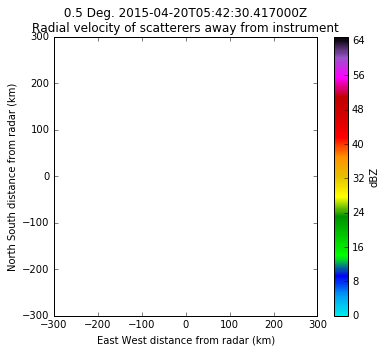

In [62]:
lenOfWeather = len(weather)-1
for i in range(lenOfWeather):
    print str(i)+"/"+str(lenOfWeather)
    print "Reading ..."
    filename = weather.iloc[i,0]
    print filename
    radar = pyart.io.read_nexrad_archive("../assets/"+filename)    
    print "Cleaning ..."
    start = time.clock()
    
    print radar.fields.keys()
    
    dzN = extract_unmasked_data(radar, 'reflectivity')
    drN = extract_unmasked_data(radar, 'differential_reflectivity')
    dpN = extract_unmasked_data(radar, 'differential_phase')
    #dvN = extract_unmasked_data(radar, 'velocity')
    
    print dvN
    
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    
    kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
    
    insect_mask = csu_misc.insect_filter(dzN, drN)
    sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=13)
    
    bad = -32768
    dz_insect = 1.0 * dzN
    dz_insect[insect_mask] = bad
    dz_sdp = 1.0 * dzN
    dz_sdp[sdp_mask] = bad
    
    
    new_mask = np.logical_or(insect_mask, sdp_mask)
    print new_mask
    dz_qc = 1.0 * dzN
    dz_qc[new_mask] = bad
    mask_ds = csu_misc.despeckle(dz_qc, ngates=15)
    dz_qc[mask_ds] = bad
    radar = add_field_to_radar_object(dz_qc, radar, field_name='DZ_qc', units='dBZ', 
                                  long_name='Reflectivity (Combo Filtered)',
                                  standard_name='Reflectivity (Combo Filtered)', 
                                  dz_field='reflectivity')
    
    
#     new_mask = np.logical_or(insect_mask, sdp_mask)
#     print new_mask
#     #dv_qc = 1.0 * dvN
#     print "Before ==============================="
#     #print dv_qc
#     dv_qc[new_mask] = bad
#     print "After  ==============================="
#     print dv_qc
#     mask_ds = csu_misc.despeckle(dv_qc)
#     radar = add_field_to_radar_object(dvN, radar, field_name='dv_qc', units='m/s', 
#                                    long_name='Velocity (Combo Filtered)',
#                                    standard_name='Reflectivity (Combo Filtered)', 
#                                    dz_field='reflectivity')
    
    end = time.clock()
    print "Time: ", end - start
    print "Saving ..."
    start = time.clock()
    cleaned_radar_image(filename,radar, sweep=0, var1='velocity', vmin1=0, vmax1=65, 
               cmap1='pyart_NWSRef', units1='dBZ',
               xlim=limN, ylim=limN)
    end = time.clock()
    break